In [1]:
import os
import pickle
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import re 

import numpy as np
import pandas as pd
import random
import time
from sklearn.utils import shuffle
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim 
import torch.utils.data as data_utils
import random
from torch.utils.data import DataLoader
from torch.nn.functional import relu,leaky_relu
from torch.nn import Linear
from torch.nn import BatchNorm1d
import networkx as nx
from rdkit import Chem
from torch_geometric import data as DATA
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.utils.data as data_utils
#from torch.utils.data import DataLoader
from math import sqrt
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import pickle
import argparse
from dl_model_architecture import NN_Encoder, GATNet, CNN_Encoder, LSTM_Encoder, Seq2Func, Seq2Func_Net, init_weights, count_parameters, training, training_net, evaluation, evaluation_net, epoch_time, evaluation_net_performance, evaluation_performance

from misc import save_model, load_model, regression_results, grid_search_cv, calculate_regression_metrics, supervised_learning_steps, get_CV_results

/home/raghvendra/anaconda3/envs/BeatAML/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Convert SMILES to graph representation
def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    if(mol is None):
        return None
    else:
        c_size = mol.GetNumAtoms()
        features = []
        for atom in mol.GetAtoms():
            feature = atom_features(atom)
            features.append( feature / sum(feature) )

        edges = []
        for bond in mol.GetBonds():
            edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        g = nx.Graph(edges).to_directed()
        edge_index = []
        for e1, e2 in g.edges:
            edge_index.append([e1, e2])
        
        return c_size, features, edge_index

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def atom_features(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na','Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb','Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H','Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr','Cr', 'Pt', 'Hg', 'Pb', 'Unknown']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    [atom.GetIsAromatic()])

def get_smiles_func(smiles, cell_features, labels):
    #Create smiles graphs
    data_list=[]
    for i in range(0,len(smiles)):
        smile = smiles[i]
        label = labels[i]
        cell_feature = cell_features[i]
        g = smile_to_graph(smile)
        if(g is None):
            print(smile)
            none_smiles.append(smile)
        else:
            c_size, features, edge_index = g[0],g[1],g[2]
            
            GCNData = DATA.Data(x=torch.FloatTensor(features),
                                    edge_index=torch.LongTensor(edge_index).transpose(1, 0),
                                    y=torch.FloatTensor([label]))
            GCNData.cell_src = torch.FloatTensor(cell_feature)
            GCNData.__setitem__('c_size', torch.LongTensor([c_size]))
            data_list.append(GCNData)
    return(data_list)

In [3]:
#Setting up the environment
SEED = 123
random.seed(SEED)
st = random.getstate()
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.cuda.is_available()
cudaid = int(0)
DEVICE = torch.device("cuda:%d" % (cudaid) if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [4]:
#Get the data for your choice: Canonical SMILES + Cell Line Info
print("Loaded training file")
big_train_df = pd.read_pickle("../Data/Training_Set_Var_with_Drug_Embedding_Cell_Info.pkl",compression="zip")
big_test_df = pd.read_pickle("../Data/Test_Set_Var_with_Drug_Embedding_Cell_Info.pkl",compression="zip")
total_length = len(big_train_df.columns)

metadata_X_train,X_train, Y_train = big_train_df.loc[:,["dbgap_rnaseq_sample","inhibitor"]], big_train_df.iloc[:,[2,1,4]+[*range(288,total_length,1)]], big_train_df["auc"].to_numpy().flatten()
metadata_X_test,X_test, Y_test = big_test_df.loc[:,["dbgap_rnaseq_sample","inhibitor"]], big_test_df.iloc[:,[2,1,4]+[*range(288,total_length,1)]], big_test_df["auc"].to_numpy().flatten()

#Keep only numeric training and test set and those which have no Nans
X_train_numerics_only = X_train.select_dtypes(include=np.number)
X_test_numerics_only = X_test[X_train_numerics_only.columns]
print("Shape of training set after removing non-numeric cols")
print(X_train_numerics_only.shape)
print(X_test_numerics_only.shape)

nan_cols = [i for i in X_train_numerics_only.columns if X_train_numerics_only[i].isnull().any()]
rev_X_train = X_train_numerics_only.drop(nan_cols,axis=1)
rev_X_test = X_test_numerics_only.drop(nan_cols,axis=1)
print("Shape of training set after removing cols with NaNs")
print(rev_X_train.shape)
print(rev_X_test.shape)

Loaded training file
Shape of training set after removing non-numeric cols
(34387, 1322)
(19184, 1322)
Shape of training set after removing cols with NaNs
(34387, 1309)
(19184, 1309)


In [5]:
#Load the tokenizer and tokenize SMILES using Vocab from DeepChem
from deepchem.feat.smiles_tokenizer import SmilesTokenizer
tokenizer = SmilesTokenizer("/home/raghvendra/TII/Projects/Raghav/Immunoinformatics/Data/vocab.txt")

max_smiles_length=150
def encode_to_indices(x):
    return(torch.tensor(tokenizer.encode(x,max_length=max_smiles_length,padding="max_length")))

#Get the list of training smiles
X_train_smiles = X_train["CanonicalSMILES"].tolist()
X_train_smiles_encoded = [encode_to_indices(x) for x in X_train_smiles]
X_test_smiles = X_test["CanonicalSMILES"].tolist()
X_test_smiles_encoded = [encode_to_indices(x) for x in X_test_smiles]

#Convert train and test smiles to stack of tensors
X_train_smiles_encoded = torch.stack(X_train_smiles_encoded)
X_test_smiles_encoded = torch.stack(X_test_smiles_encoded)

#Convert the cell line info into scaled vectors
scaler = preprocessing.StandardScaler()
X_train_copy = scaler.fit_transform(rev_X_train)
X_test_copy = scaler.transform(rev_X_test)

#Get the list of training smiles
X_train_smiles = X_train["CanonicalSMILES"].tolist()
X_train_smiles_graphs = get_smiles_func(X_train_smiles,X_train_copy,Y_train)
X_test_smiles = X_test["CanonicalSMILES"].tolist()
X_test_smiles_graphs = get_smiles_func(X_test_smiles,X_test_copy,Y_test)

#Create the training and test tensor datasets
train = data_utils.TensorDataset(X_train_smiles_encoded, torch.Tensor(np.array(X_train_copy)),torch.Tensor(np.array(Y_train)))
test = data_utils.TensorDataset(X_test_smiles_encoded, torch.Tensor(np.array(X_test_copy)),torch.Tensor(np.array(Y_test)))

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.
/tmp/ipykernel_24239/2320685607.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  GCNData = DATA.Data(x=torch.FloatTensor(features),


In [6]:
#Running the code for GAT model
N_dim = rev_X_train.shape[1]
best_model=None
valid_metrics_set = []
cur_best_MAE = np.Inf
for i in range(0,10):
    #Split the data into 0.8 for training and rest for validation stuff
    BATCH_SIZE = 256
    train_dataset, valid_dataset = data_utils.random_split(X_train_smiles_graphs, [0.8, 0.2], generator = torch.Generator().manual_seed(i*42))
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(X_test_smiles_graphs, batch_size=BATCH_SIZE, shuffle=False)
    
    #Build model parameters
    CELL_INPUT_DIM = X_train_copy.shape[1]
    CELL_OUT_DIM = 256
    CELL_HID_DIMS = [1024,512]

    SMILES_INPUT_DIM = 78
    SMILES_N_HEAD = 2
    SMILES_HID_DIM = 256
    SMILES_OUT_DIM = 256

    HID_DIM = 128
    OUT_DIM = 1
    DROPOUT = 0.2

    cell_enc = NN_Encoder(CELL_INPUT_DIM, CELL_OUT_DIM, CELL_HID_DIMS, DROPOUT)
    smiles_enc = GATNet(SMILES_INPUT_DIM, SMILES_N_HEAD, SMILES_HID_DIM, SMILES_OUT_DIM, DROPOUT)

    #Make the model
    model = Seq2Func_Net(cell_enc, smiles_enc, HID_DIM, OUT_DIM, DROPOUT, device=DEVICE).to(DEVICE)
    
    #Model training criterion
    optimizer = optim.Adam(model.parameters(),weight_decay=1e-4)
    criterion = nn.MSELoss().to(DEVICE)
    
    inputfile_model = '../Models/gat_models/gat_supervised_checkpoint_'+str(i)+'.pt'
    if (torch.cuda.is_available()):
        model.load_state_dict(torch.load(inputfile_model))
    else:
        model.load_state_dict(torch.load(inputfile_model,map_location=torch.device('cpu')))
        
    valid_outputs = evaluation_net_performance(model, valid_loader, criterion, N_dim, DEVICE)
    valid_metrics = calculate_regression_metrics(labels=np.array(valid_outputs[1]),predictions=np.array(valid_outputs[0]))
    valid_metrics_set.append(valid_metrics)
    if (valid_metrics[0]<cur_best_MAE):
        cur_best_MAE = valid_metrics[0]
        best_model = model

In [9]:
#Evaluation of the GAT model
valid_metrics_df = pd.DataFrame(valid_metrics_set)
mean_valid_metrics = pd.DataFrame.mean(valid_metrics_df,axis=0)
print(mean_valid_metrics)
sd_valid_metrics = pd.DataFrame.std(valid_metrics_df,axis=0)
print(sd_valid_metrics)
test_outputs = evaluation_net_performance(best_model, test_loader, criterion, N_dim, DEVICE)
test_metrics = calculate_regression_metrics(labels=np.array(test_outputs[1]),predictions=np.array(test_outputs[0]))
print(test_metrics)

#Write the prediction of GATNet model
metadata_X_test['predictions']=np.array(test_outputs[0])
metadata_X_test['labels']=np.array(test_outputs[1])
metadata_X_test.to_csv("../Results/GATNet_supervised_test_predictions.csv",index=False,sep="\t")
print("Finished writing predictions")

0    26.3122
1    37.1113
2     0.6433
3     0.8020
4     0.7996
dtype: float64
0    0.369915
1    0.643790
2    0.006865
3    0.004190
4    0.005719
dtype: float64
(40.697, 54.904, 0.393, 0.627, 0.617)
Finished writing predictions


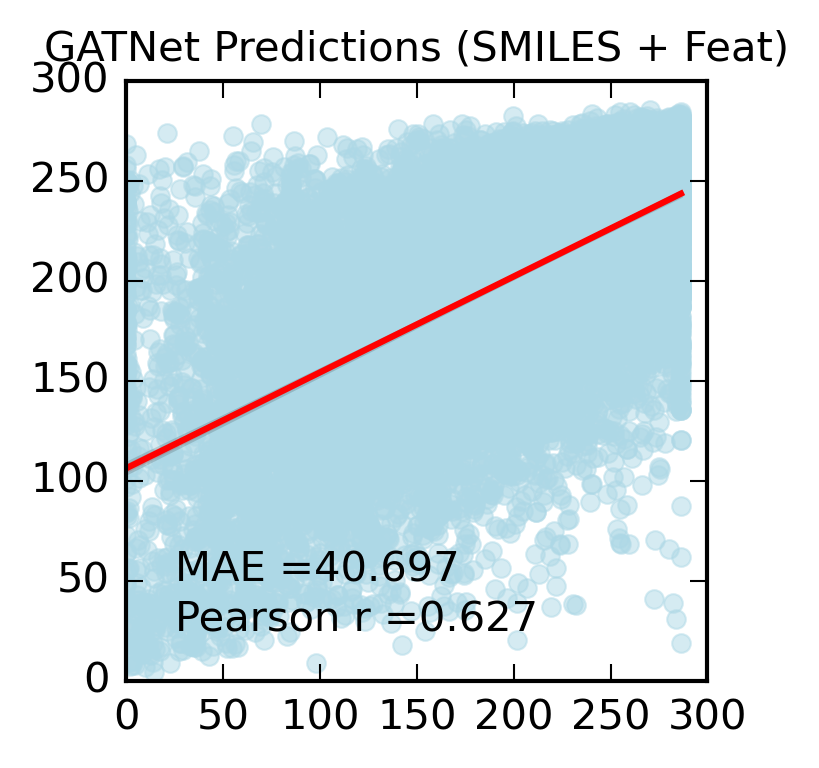

In [10]:
fig = plt.figure()
plt.style.use('classic')
fig.set_size_inches(2.5,2.5)
fig.set_dpi(300)
fig.set_facecolor("white")

ax = sn.regplot(x="labels", y="predictions", data=metadata_X_test, scatter_kws={"color": "lightblue",'alpha':0.5}, 
                line_kws={"color": "red"})
ax.axes.set_title("GATNet Predictions (SMILES + Feat)",fontsize=10)
ax.set_xlim(0, 300)
ax.set_ylim(0, 300)
ax.set_xlabel("",fontsize=10)
ax.set_ylabel("",fontsize=10)
ax.tick_params(labelsize=10, color="black")
plt.text(25, 25, 'Pearson r =' +str(test_metrics[3]), fontsize = 10)
plt.text(25, 50, 'MAE ='+str(test_metrics[0]),fontsize=10)
outfilename = "../Results/GATNet_supervised_test_prediction.pdf"
plt.savefig(outfilename, bbox_inches="tight")

In [11]:
best_cnn_model=None
cnn_valid_metrics_set = []
cur_best_MAE = np.Inf
for i in range(0,10):
    #Split the data into 0.8 for training and rest for validation stuff
    BATCH_SIZE = 256
    train_dataset, valid_dataset = data_utils.random_split(train, [0.8, 0.2], generator = torch.Generator().manual_seed(i*42))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
    
    #Build model parameters
    CELL_INPUT_DIM = X_train_copy.shape[1]
    CELL_OUT_DIM = 256
    CELL_HID_DIMS = [1024,512]

    SMILES_INPUT_DIM = tokenizer.vocab_size
    SMILES_ENC_EMB_DIM = 128
    SMILES_OUT_DIM = 256

    N_FILTERS = 64
    FILTER_SIZES = [2,3,4,6,7,8,9,10]

    HID_DIM = 256
    OUT_DIM = 1
    DROPOUT = 0.2

    cell_enc = NN_Encoder(CELL_INPUT_DIM, CELL_OUT_DIM, CELL_HID_DIMS, DROPOUT)
    smiles_enc = CNN_Encoder(SMILES_INPUT_DIM, SMILES_ENC_EMB_DIM, SMILES_OUT_DIM, N_FILTERS, FILTER_SIZES, DROPOUT)

    #Make the model
    model = Seq2Func(cell_enc, smiles_enc, HID_DIM, OUT_DIM, DROPOUT, device=DEVICE).to(DEVICE)
    print("Total parameters in model are: ",count_parameters(model))
    model.apply(init_weights)
    
    #Model training criterion
    optimizer = optim.Adam(model.parameters(),weight_decay=1e-4)
    criterion = nn.MSELoss().to(DEVICE)
    
    inputfile_model = '../Models/cnn_models/cnn_supervised_checkpoint_'+str(i)+'.pt'
    if (torch.cuda.is_available()):
        model.load_state_dict(torch.load(inputfile_model))
    else:
        model.load_state_dict(torch.load(inputfile_model,map_location=torch.device('cpu')))
                
    cnn_valid_outputs = evaluation_performance(model, valid_loader, criterion, DEVICE)
    cnn_valid_metrics = calculate_regression_metrics(labels=np.array(cnn_valid_outputs[1]),predictions=np.array(cnn_valid_outputs[0]))
    cnn_valid_metrics_set.append(cnn_valid_metrics)
    if (cnn_valid_metrics[0]<cur_best_MAE):
        cur_best_MAE = cnn_valid_metrics[0]
        best_model = model

Total parameters in model are:  2742273
Total parameters in model are:  2742273
Total parameters in model are:  2742273
Total parameters in model are:  2742273
Total parameters in model are:  2742273
Total parameters in model are:  2742273
Total parameters in model are:  2742273
Total parameters in model are:  2742273
Total parameters in model are:  2742273
Total parameters in model are:  2742273


In [16]:
#Evaluation of the GAT model
cnn_valid_metrics_df = pd.DataFrame(cnn_valid_metrics_set)
mean_cnn_valid_metrics = pd.DataFrame.mean(cnn_valid_metrics_df,axis=0)
print(mean_cnn_valid_metrics)
sd_cnn_valid_metrics = pd.DataFrame.std(cnn_valid_metrics_df,axis=0)
print(sd_cnn_valid_metrics)
cnn_test_outputs = evaluation_performance(best_model, test_loader, criterion, DEVICE)
cnn_test_metrics = calculate_regression_metrics(labels=np.array(cnn_test_outputs[1]),predictions=np.array(cnn_test_outputs[0]))
print(cnn_test_metrics)

#Write the prediction of CNN model
cnn_metadata_X_test = big_test_df.loc[:,["dbgap_rnaseq_sample","inhibitor"]]
cnn_metadata_X_test['predictions']=np.array(cnn_test_outputs[0])
cnn_metadata_X_test['labels']=np.array(cnn_test_outputs[1])
cnn_metadata_X_test.to_csv("../Results/CNN_supervised_test_predictions.csv",index=False,sep="\t")
print("Finished writing predictions")

0    26.0259
1    37.0308
2     0.6455
3     0.8032
4     0.7999
dtype: float64
0    0.227943
1    0.489467
2    0.006737
3    0.004264
4    0.004122
dtype: float64
(40.853, 55.6, 0.397, 0.63, 0.627)
Finished writing predictions


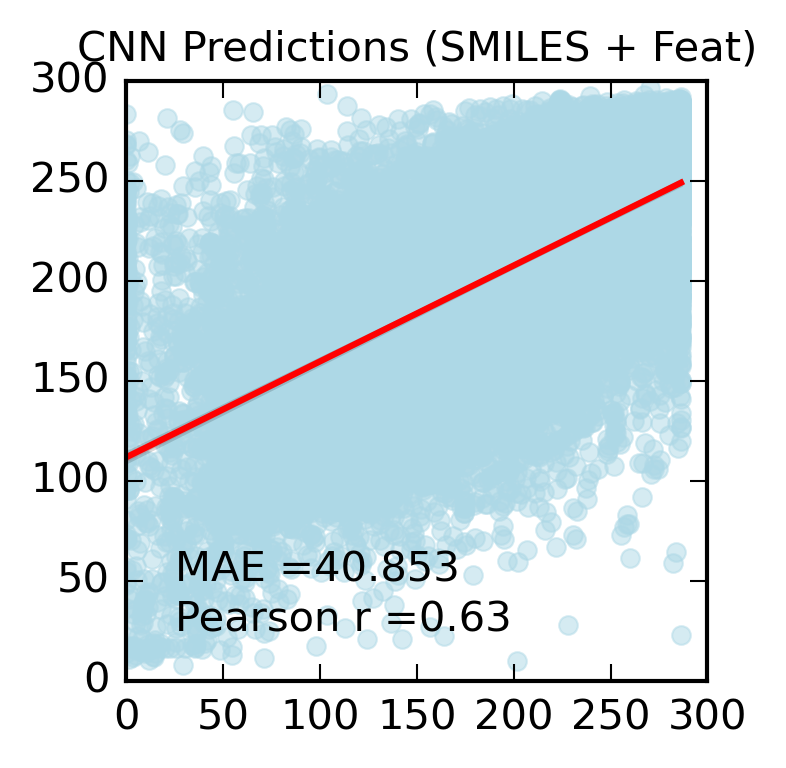

In [18]:
fig = plt.figure()
plt.style.use('classic')
fig.set_size_inches(2.5,2.5)
fig.set_dpi(300)
fig.set_facecolor("white")

ax = sn.regplot(x="labels", y="predictions", data=cnn_metadata_X_test, scatter_kws={"color": "lightblue",'alpha':0.5}, 
                line_kws={"color": "red"})
ax.axes.set_title("CNN Predictions (SMILES + Feat)",fontsize=10)
ax.set_xlim(0, 300)
ax.set_ylim(0, 300)
ax.set_xlabel("",fontsize=10)
ax.set_ylabel("",fontsize=10)
ax.tick_params(labelsize=10, color="black")
plt.text(25, 25, 'Pearson r =' +str(cnn_test_metrics[3]), fontsize = 10)
plt.text(25, 50, 'MAE ='+str(cnn_test_metrics[0]),fontsize=10)
outfilename = "../Results/CNN_supervised_test_prediction.pdf"
plt.savefig(outfilename, bbox_inches="tight")

In [19]:
best_lstm_model=None
lstm_valid_metrics_set = []
cur_best_MAE = np.Inf
for i in range(0,10):
    #Split the data into 0.8 for training and rest for validation stuff
    BATCH_SIZE = 256
    train_dataset, valid_dataset = data_utils.random_split(train, [0.8, 0.2], generator = torch.Generator().manual_seed(i*42))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
    
    #Build model parameters
    CELL_INPUT_DIM = X_train_copy.shape[1]
    CELL_OUT_DIM = 256
    CELL_HID_DIMS = [1024,512]

    SMILES_INPUT_DIM = tokenizer.vocab_size
    SMILES_ENC_EMB_DIM = 128
    SMILES_HID_DIM = 256
    SMILES_OUT_DIM = 256

    HID_DIM = 128
    OUT_DIM = 1
    N_LAYERS = 2
    DROPOUT = 0.2

    cell_enc = NN_Encoder(CELL_INPUT_DIM, CELL_OUT_DIM, CELL_HID_DIMS, DROPOUT)
    smiles_enc = LSTM_Encoder(SMILES_INPUT_DIM, SMILES_ENC_EMB_DIM, SMILES_HID_DIM, SMILES_OUT_DIM, N_LAYERS, DROPOUT)

    #Make the model
    model = Seq2Func(cell_enc, smiles_enc, HID_DIM, OUT_DIM, DROPOUT, device=DEVICE).to(DEVICE)
    print("Total parameters in model are: ",count_parameters(model))
    model.apply(init_weights)
    
    #Model training criterion
    optimizer = optim.Adam(model.parameters(),weight_decay=1e-4)
    criterion = nn.MSELoss().to(DEVICE)
    
    inputfile_model = '../Models/lstm_models/lstm_supervised_checkpoint_'+str(i)+'.pt'
    if (torch.cuda.is_available()):
        model.load_state_dict(torch.load(inputfile_model))
    else:
        model.load_state_dict(torch.load(inputfile_model,map_location=torch.device('cpu')))
                
    lstm_valid_outputs = evaluation_performance(model, valid_loader, criterion, DEVICE)
    lstm_valid_metrics = calculate_regression_metrics(labels=np.array(lstm_valid_outputs[1]),predictions=np.array(lstm_valid_outputs[0]))
    lstm_valid_metrics_set.append(lstm_valid_metrics)
    if (lstm_valid_metrics[0]<cur_best_MAE):
        cur_best_MAE = lstm_valid_metrics[0]
        best_model = model

Total parameters in model are:  3195521
Total parameters in model are:  3195521
Total parameters in model are:  3195521
Total parameters in model are:  3195521
Total parameters in model are:  3195521
Total parameters in model are:  3195521
Total parameters in model are:  3195521
Total parameters in model are:  3195521
Total parameters in model are:  3195521
Total parameters in model are:  3195521


In [20]:
#Evaluation of the GAT model
lstm_valid_metrics_df = pd.DataFrame(lstm_valid_metrics_set)
mean_lstm_valid_metrics = pd.DataFrame.mean(lstm_valid_metrics_df,axis=0)
print(mean_lstm_valid_metrics)
sd_lstm_valid_metrics = pd.DataFrame.std(lstm_valid_metrics_df,axis=0)
print(sd_lstm_valid_metrics)
lstm_test_outputs = evaluation_performance(best_model, test_loader, criterion, DEVICE)
lstm_test_metrics = calculate_regression_metrics(labels=np.array(lstm_test_outputs[1]),predictions=np.array(lstm_test_outputs[0]))
print(lstm_test_metrics)

#Write the prediction of CNN model
lstm_metadata_X_test = big_test_df.loc[:,["dbgap_rnaseq_sample","inhibitor"]]
lstm_metadata_X_test['predictions']=np.array(lstm_test_outputs[0])
lstm_metadata_X_test['labels']=np.array(lstm_test_outputs[1])
lstm_metadata_X_test.to_csv("../Results/LSTM_supervised_test_predictions.csv",index=False,sep="\t")
print("Finished writing predictions")

0    26.2674
1    36.8707
2     0.6447
3     0.8029
4     0.7990
dtype: float64
0    0.420244
1    0.610936
2    0.007558
3    0.004654
4    0.005558
dtype: float64
(40.698, 55.136, 0.389, 0.624, 0.618)
Finished writing predictions


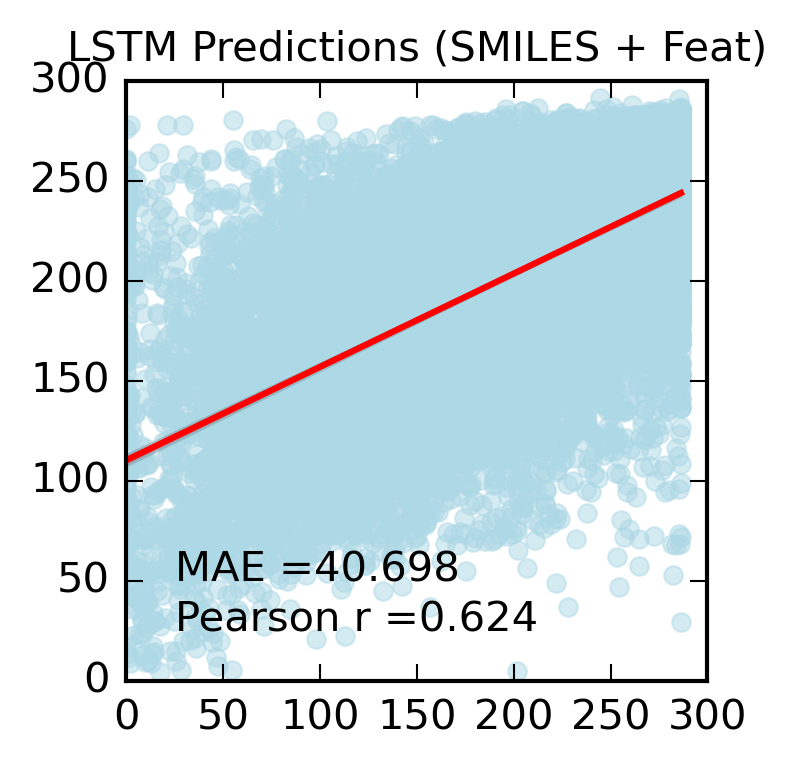

In [21]:
fig = plt.figure()
plt.style.use('classic')
fig.set_size_inches(2.5,2.5)
fig.set_dpi(300)
fig.set_facecolor("white")

ax = sn.regplot(x="labels", y="predictions", data=lstm_metadata_X_test, scatter_kws={"color": "lightblue",'alpha':0.5}, 
                line_kws={"color": "red"})
ax.axes.set_title("LSTM Predictions (SMILES + Feat)",fontsize=10)
ax.set_xlim(0, 300)
ax.set_ylim(0, 300)
ax.set_xlabel("",fontsize=10)
ax.set_ylabel("",fontsize=10)
ax.tick_params(labelsize=10, color="black")
plt.text(25, 25, 'Pearson r =' +str(lstm_test_metrics[3]), fontsize = 10)
plt.text(25, 50, 'MAE ='+str(lstm_test_metrics[0]),fontsize=10)
outfilename = "../Results/LSTM_supervised_test_prediction.pdf"
plt.savefig(outfilename, bbox_inches="tight")